In [ ]:
! pip install langgraph langchain_openai langchain_community chromadb langchain_experimental --q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.7/202.7 kB 4.0 MB/s eta 0:00:00


### Build a simple LangGraph with Nodes and Edges

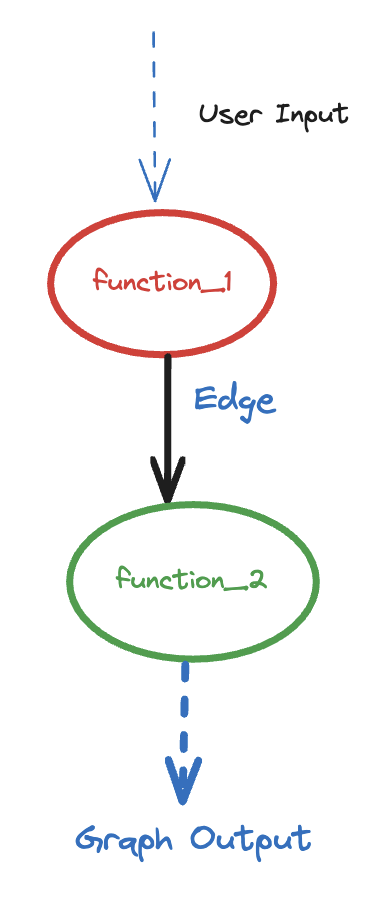

In [ ]:
def function_1(input_1):
    return input_1 + " First Function "

def function_2(input_2):
    return input_2 + " to Second Function"

In [ ]:
from langgraph.graph import Graph

# Define a Langchain graph
workflow = Graph()

workflow.add_node("node_1", function_1)
workflow.add_node("node_2", function_2)

workflow.add_edge('node_1', 'node_2')

workflow.set_entry_point("node_1")
workflow.set_finish_point("node_2")

app = workflow.compile()

In [ ]:
app.invoke('I am moving from')


'I am moving from First Function  to Second Function'

In [ ]:
input = 'I am moving from'
for output in app.stream(input):
    # stream() yields dictionaries with output keyed by node name
    for key, value in output.items():
        print(f"Output from node '{key}':")
        print("---")
        print(value)
    print("\n---\n")

Output from node 'node_1':
---
I am moving from First Function 

---

Output from node 'node_2':
---
I am moving from First Function  to Second Function

---



Integrating LLM call in the LangGraph

In [ ]:
from google.colab import userdata
import os
os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_KEY')

In [ ]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI()

llm.invoke('What is an Large Language Model Agents?')

AIMessage(content="Large Language Model Agents are advanced artificial intelligence models designed to understand and generate human language. These models are trained on vast amounts of text data and use deep learning techniques to learn the structure and patterns of language. They are able to generate coherent and contextually relevant text, engage in conversations, and perform a variety of language-related tasks such as translation, summarization, and question-answering. Examples of Large Language Model Agents include OpenAI's GPT-3 and Google's BERT.", response_metadata={'token_usage': {'completion_tokens': 99, 'prompt_tokens': 15, 'total_tokens': 114}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-8d52b1cc-b375-4595-abde-29ed137ebfdc-0', usage_metadata={'input_tokens': 15, 'output_tokens': 99, 'total_tokens': 114})

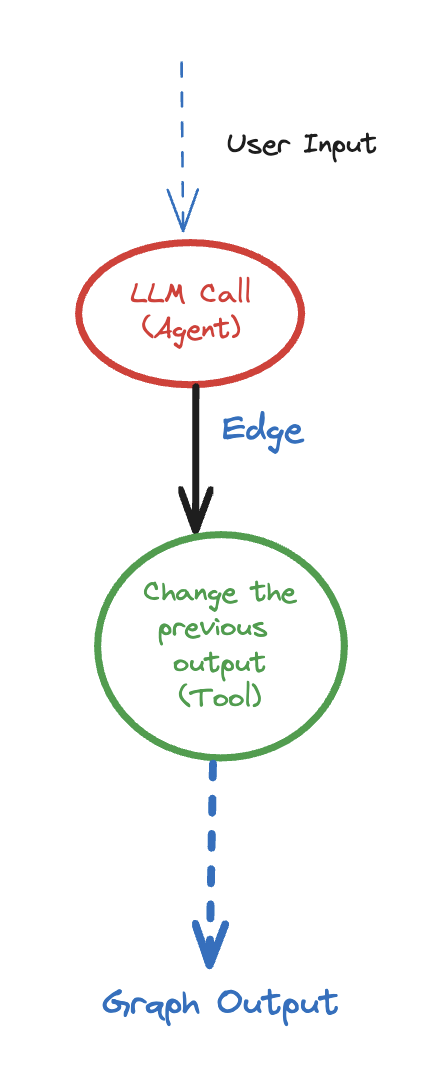

In [ ]:
def function_1(input_1):
    complete_query = "Your task is to provide only the topic based on the user query. \
        Only output the topic among: [Japan , Sports]. Don't include reasoning. Following is the user query: " + input_1
    response = llm.invoke(complete_query)
    return response.content

def function_2(input_2):
    TOPIC_UPPER = input_2.upper()
    response = f"Here is the topic in UPPER case: {TOPIC_UPPER}"
    return response

In [ ]:
# Define a Langchain graph
workflow = Graph()

workflow.add_node("Agent", function_1)
workflow.add_node("tool", function_2)

workflow.add_edge('Agent', 'tool')

workflow.set_entry_point("Agent")
workflow.set_finish_point("tool")

app = workflow.compile()

In [ ]:
query = "Tell me about Japan's Industrial Growth"

for output in app.stream(query):
    # stream() yields dictionaries with output keyed by node name
    for key, value in output.items():
        print(f"Output from node '{key}':")
        print("---")
        print(value)
    print("\n---\n")

Output from node 'Agent':
---
Japan

---

Output from node 'tool':
---
Here is the topic in UPPER case: JAPAN

---



In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


### RAG - Vector DB Population

In [ ]:
from langchain_community.document_loaders import TextLoader, DirectoryLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma

### Reading the txt files from source directory

loader = DirectoryLoader('/content/drive/MyDrive/source', glob="./*.txt", loader_cls=TextLoader)
docs = loader.load()

### Creating Chunks using RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=100,
    chunk_overlap=10,
    length_function=len
)
new_docs = text_splitter.split_documents(documents=docs)
doc_strings = [doc.page_content for doc in new_docs]

###  BGE Embddings

from langchain_openai import OpenAIEmbeddings


embeddings = OpenAIEmbeddings()

### Creating Retriever using Vector DB

db = Chroma.from_documents(new_docs, embeddings)
retriever = db.as_retriever(search_kwargs={"k": 4})

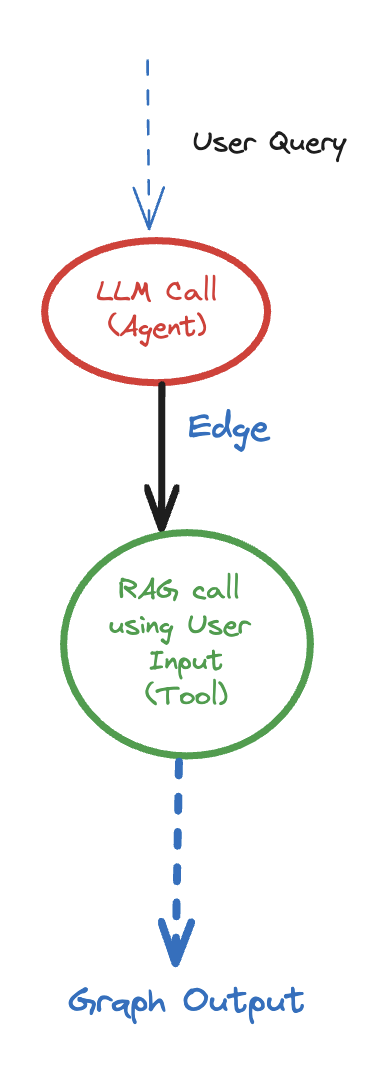

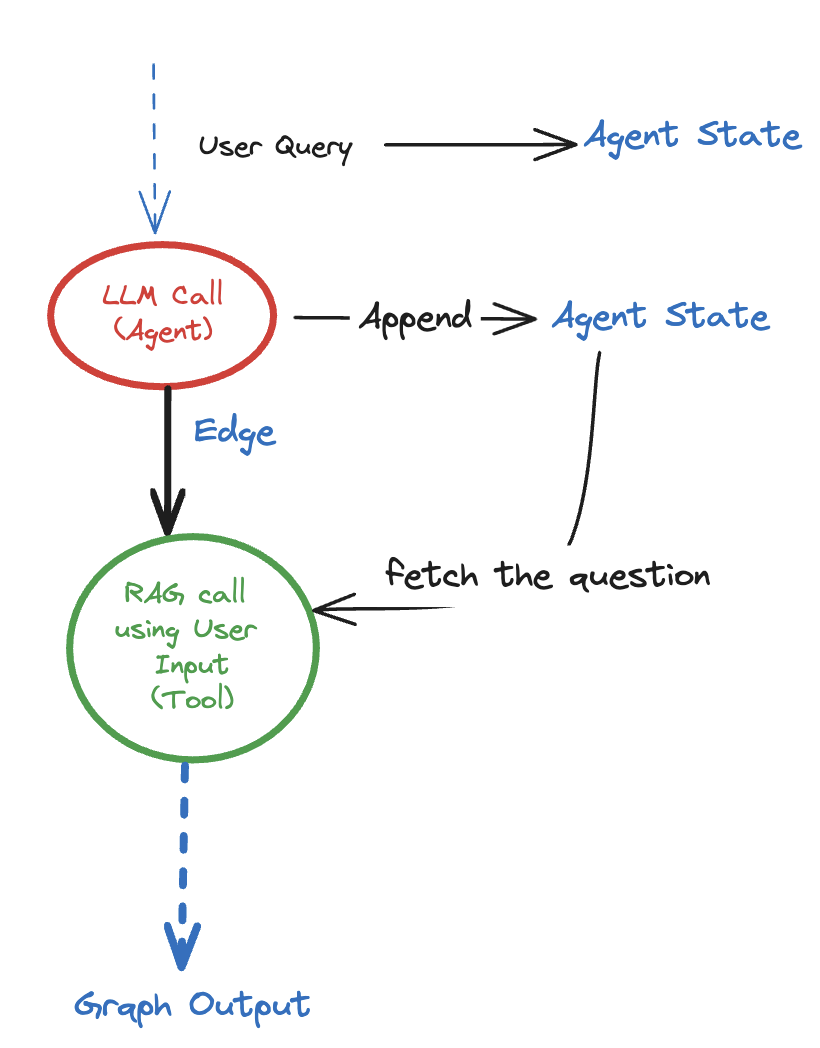

In [ ]:
from typing import TypedDict, Annotated, Sequence
import operator
from langchain_core.messages import BaseMessage


class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

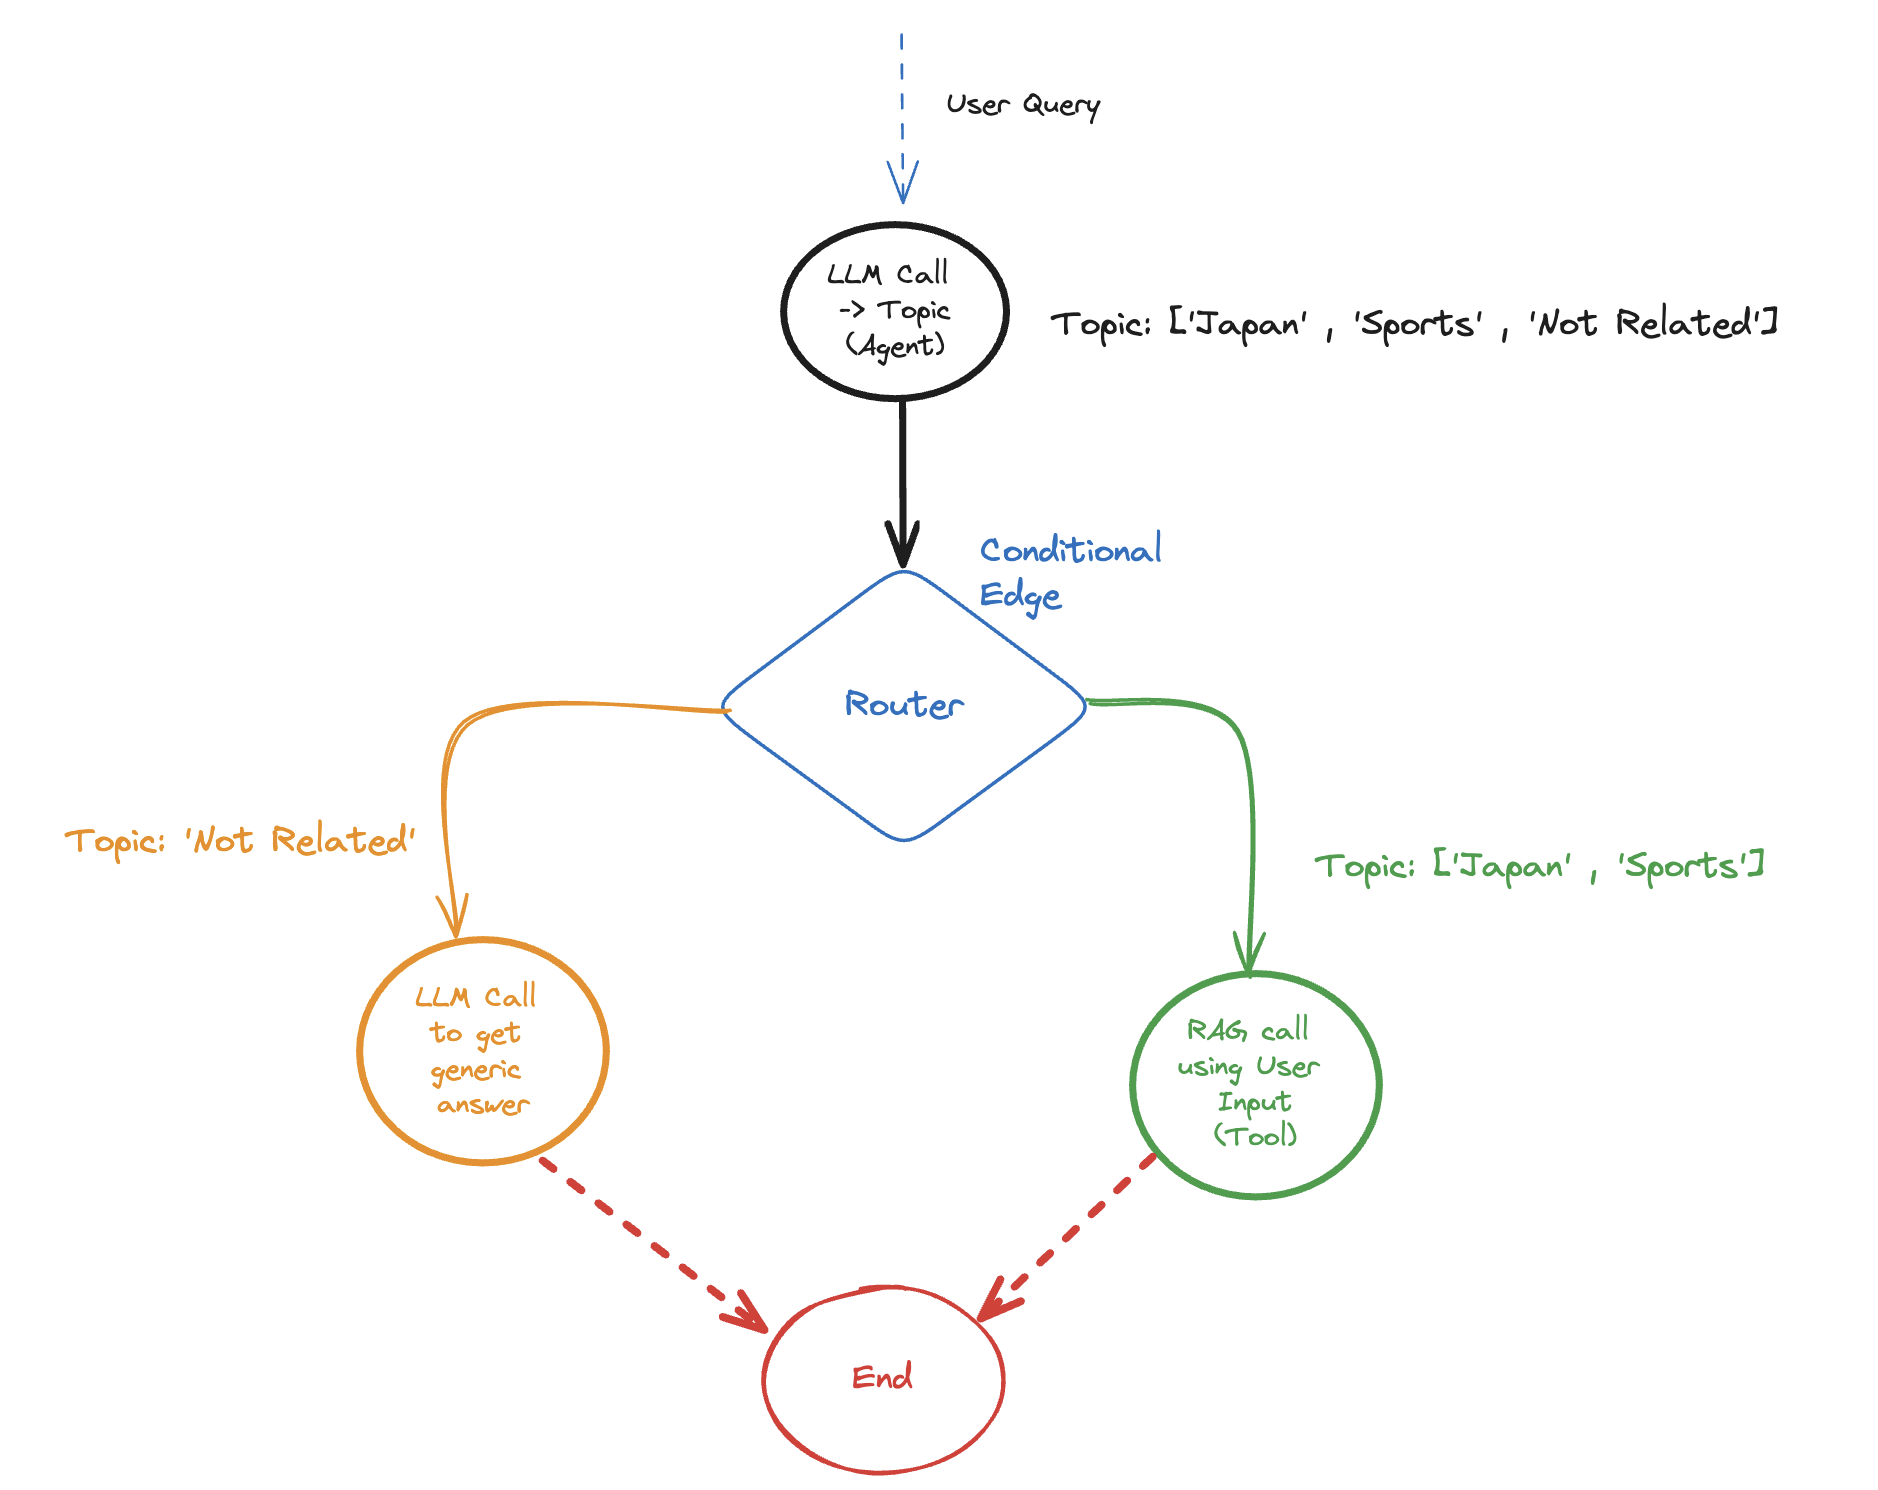

In [ ]:
from langchain.output_parsers import PydanticOutputParser
from langchain_core.output_parsers import StrOutputParser
from pydantic import BaseModel , Field
from langchain.prompts import PromptTemplate , ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain.chains import RetrievalQA


class TopicSelectionParser(BaseModel):
    Topic: str = Field(description='Selected Topic')

parser = PydanticOutputParser(pydantic_object=TopicSelectionParser)

In [ ]:
def function_1(state):
    print('-> Calling Agent ->')
    messages = state['messages']
    question = messages[-1]   ## Fetching the user question

    templete = """ Your task is to provide only the topic based on the user query.
        Only output the topic among: [Japan , Sports , Not Related]. Don't include reasoning. Following is the user query:  {question}
        {format_instructions} """
    prompt = PromptTemplate(template=templete,
                                    input_variables=[question],
                                    partial_variables={
                                        "format_instructions" : parser.get_format_instructions()                                    }
                                    )
    chain = prompt | llm | parser

    response = chain.invoke({"question":question,"format_instructions" : parser.get_format_instructions() })

    print(response)

    return {"messages": [response.Topic]}

def function_2(state):
    print('-> Calling RAG ->')
    messages = state['messages']
    question = messages[0] ## Fetching the user question

    template = """Answer the question based only on the following context:
    {context}

    Question: {question}
    """
    prompt = ChatPromptTemplate.from_template(template)

    retrieval_chain = (
        {"context": retriever, "question": RunnablePassthrough()}
        | prompt
        | llm
        | StrOutputParser()
        )
    result = retrieval_chain.invoke(question)
    return  {"messages": [result]}

def function_3(state):
    print('-> Calling LLM ->')

    messages = state['messages']
    question = messages[0] ## Fetching the user question

    # Normal LLM call
    complete_query = "Anwer the follow question with you knowledge of the real world. Following is the user question: " + question
    response = llm.invoke(complete_query)
    return {"messages": [response.content]}


def router(state):
    print('-> Router ->')

    messages = state["messages"]
    last_message = messages[-1]
    print(last_message)
    if 'Japan' in last_message or 'Sports' in last_message:
        return 'RAG Call'
    else:
        return 'LLM Call'

In [ ]:
from langgraph.graph import StateGraph,END

graph = StateGraph(AgentState) ### StateGraph with AgentState

graph.add_node("agent", function_1)
graph.add_node("RAG", function_2)
graph.add_node("LLM", function_3)

graph.set_entry_point("agent")


# conditional edges are controlled by our router
graph.add_conditional_edges(
    "agent",  # where in graph to start
    router,  # function to determine which node is called
    {
        "RAG Call": "RAG",
        "LLM Call": "LLM",
    }
)

graph.add_edge("RAG", END)
graph.add_edge("LLM", END)

app = graph.compile()

In [ ]:
inputs = {"messages": ["Tell me about Japan's Industrial Growth"]}
out = app.invoke(inputs)

-> Calling Agent ->
Topic='Japan'
-> Router ->
Japan
-> Calling RAG ->


In [ ]:
out['messages'][-1]

"Based on the context provided, Japan's industrial growth is growing faster than expected, which is boosting hopes for the country's economic revival. Additionally, exports, which are normally the engine for Japan's economy in the face of weak domestic demand, have helped in this growth."

In [ ]:
inputs = {"messages": ["Tell me about Bert Model"]}
out = app.invoke(inputs)
out['messages'][-1]

-> Calling Agent ->
Topic='Not Related'
-> Router ->
Not Related
-> Calling LLM ->


'The Bert Model, also known as Bidirectional Encoder Representations from Transformers, is a pre-trained natural language processing model developed by Google in 2018. It is based on the Transformer architecture and is designed to understand and process natural language text. The Bert Model has been widely used in various NLP tasks such as text classification, question answering, and text generation. It has been shown to achieve state-of-the-art performance on several benchmark datasets and has become a popular choice for NLP researchers and practitioners.'

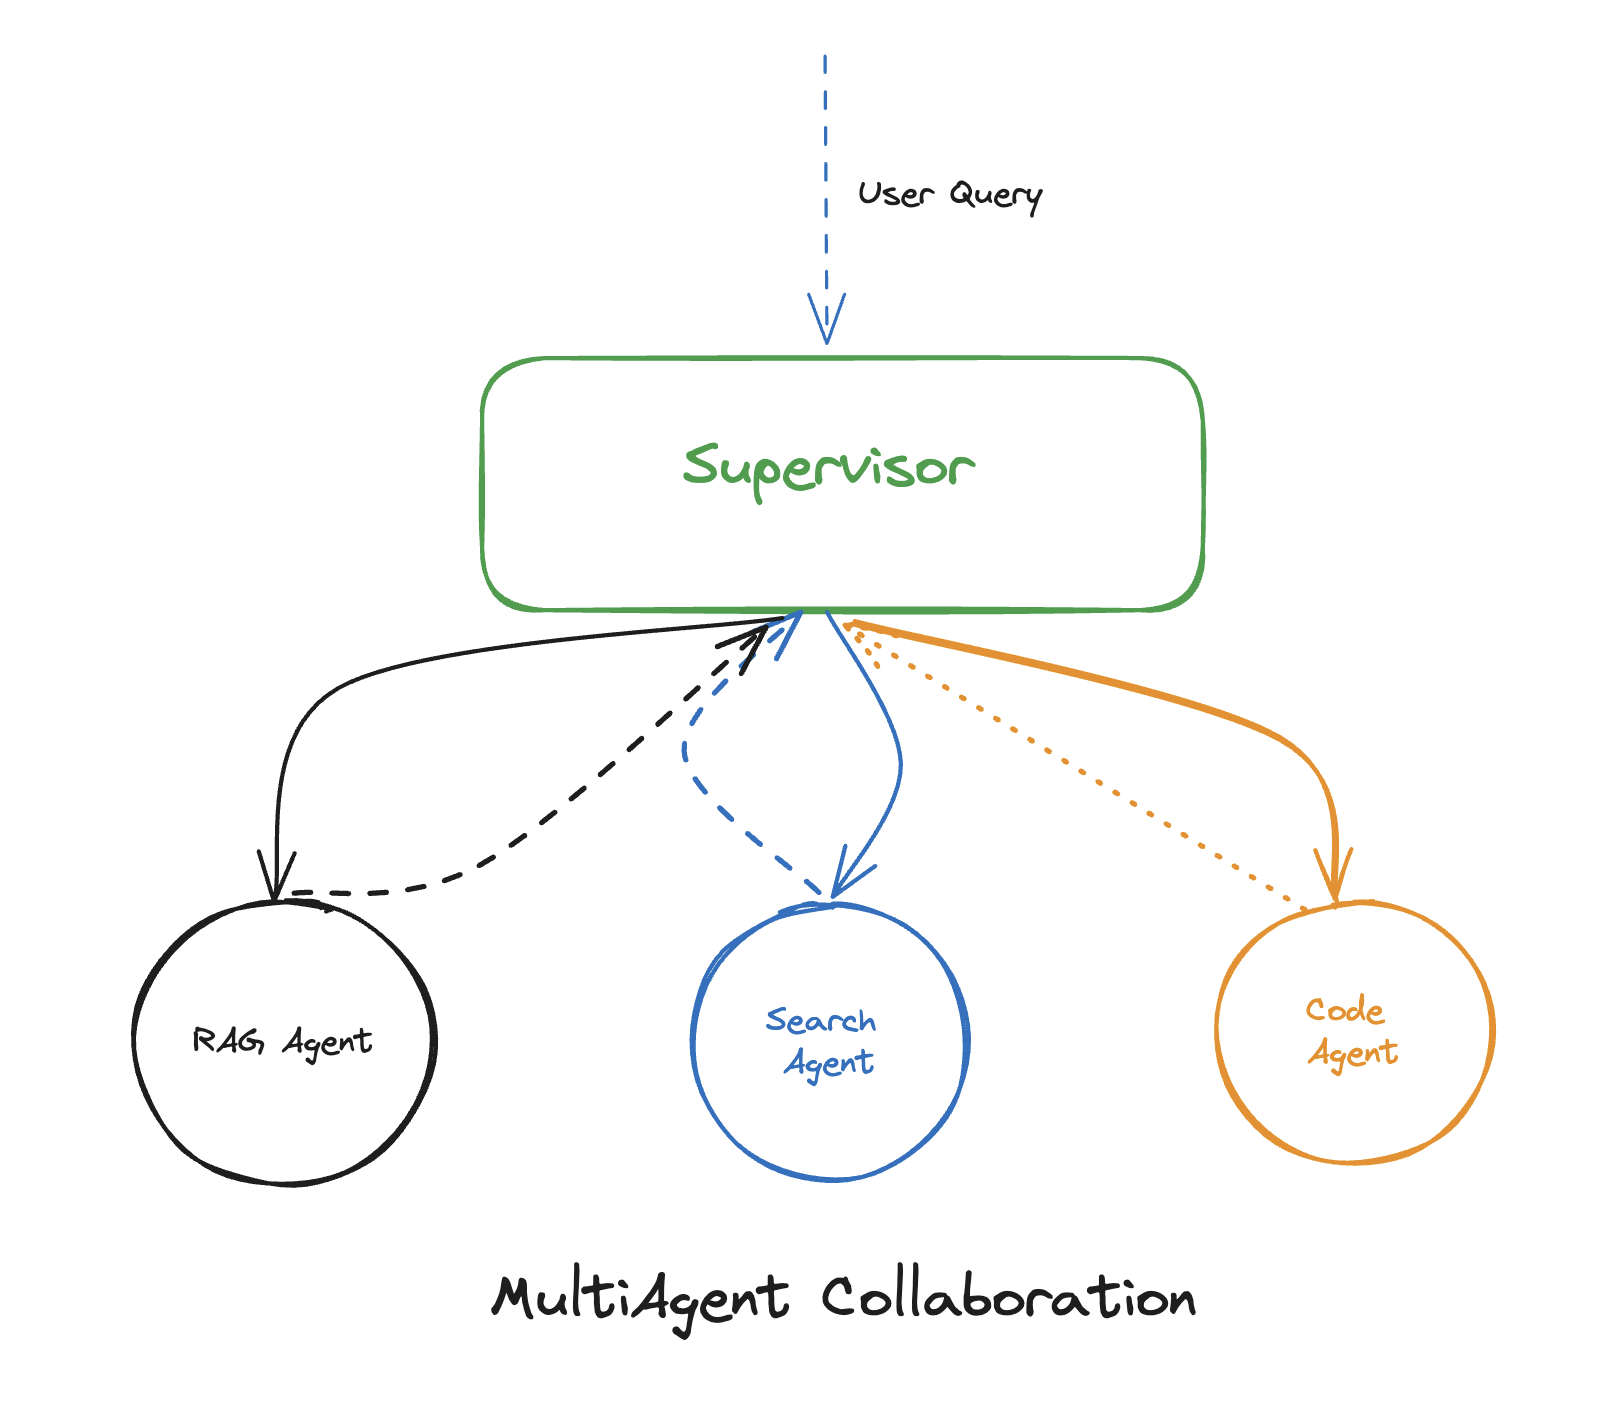

In [ ]:
os.environ['TAVILY_API_KEY'] = userdata.get("TAVILY")

In [ ]:
from langchain.agents import AgentExecutor, create_openai_tools_agent
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_openai import ChatOpenAI


def create_agent(llm: ChatOpenAI, tools: list, system_prompt: str):
    # Each worker node will be given a name and some tools.
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                system_prompt,
            ),
            MessagesPlaceholder(variable_name="messages"),
            MessagesPlaceholder(variable_name="agent_scratchpad"),
        ]
    )
    agent = create_openai_tools_agent(llm, tools, prompt)
    executor = AgentExecutor(agent=agent, tools=tools)
    return executor

In [ ]:
from typing import Annotated, List, Tuple, Union

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.tools import PythonREPLTool

tavily_tool = TavilySearchResults(max_results=2)

python_repl_tool = PythonREPLTool()

In [ ]:
@tool
def RAG(state):

    """Use this to execute RAG. If the question is related to Japan or Sports, using this tool retrieve the results."""

    print('-> Calling RAG ->')
    question = state
    print('Question:',question)

    template = """Answer the question based only on the following context:
    {context}

    Question: {question}
    """
    prompt = ChatPromptTemplate.from_template(template)

    retrieval_chain = (
        {"context": retriever, "question": RunnablePassthrough()}
        | prompt
        | llm
        | StrOutputParser()
        )
    result = retrieval_chain.invoke(question)
    return result

Agent node

- takes state , agent and name as input
- return mesage as HumanMessage with name

In [ ]:
def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["output"], name=name)]}

#### Supervisor Chain creation

Our team supervisor is an LLM node. It just picks the next agent to process and decides when the work is completed

Has access and information about it's memebers.

members = ["RAG" , "Researcher", "Coder"]

options = ["FINISH"] + members

"Given the conversation above, who should act next?" " Or should we FINISH? Select one of: {options}"

Router -> function_def

In [ ]:
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

members = ["RAG" , "Researcher", "Coder"]
system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  {members}. Given the following user request,"
    " respond with the worker to act next. Use RAG tool when questions "
     "are related to Japan or of Sports category. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)

options = ["FINISH"] + members
# Using openai function calling can make output parsing easier for us
function_def = {
    "name": "route",
    "description": "Select the next role.",
    "parameters": {
        "title": "routeSchema",
        "type": "object",
        "properties": {
            "next": {
                "title": "Next",
                "anyOf": [
                    {"enum": options},
                ],
            }
        },
        "required": ["next"],
    },
}
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above, who should act next?"
            " Or should we FINISH? Select one of: {options}",
        ),
    ]
).partial(options=str(options), members=", ".join(members))

supervisor_chain = (
    prompt
    | llm.bind_functions(functions=[function_def], function_call="route")
    | JsonOutputFunctionsParser()
)

#### Creation of workflow with below nodes

Agent ->> Node (functools.partial)

Research Node
Code Node
RAG Node

In [ ]:
import operator
from typing import Annotated, Any, Dict, List, Optional, Sequence, TypedDict
import functools

from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import StateGraph, END


# The agent state is the input to each node in the graph
class AgentState(TypedDict):
    # The annotation tells the graph that new messages will always
    # be added to the current states
    messages: Annotated[Sequence[BaseMessage], operator.add]
    # The 'next' field indicates where to route to next
    next: str


research_agent = create_agent(llm, [tavily_tool], "You are a web researcher.")
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

# NOTE: THIS PERFORMS ARBITRARY CODE EXECUTION. PROCEED WITH CAUTION
code_agent = create_agent(
    llm,
    [python_repl_tool],
    "You may generate safe python code to analyze data and generate charts using matplotlib.",
)
code_node = functools.partial(agent_node, agent=code_agent, name="Coder")


RAG_agent = create_agent(
    llm,
    [RAG],
    "Use this tools when questions are related to Japan or of Sports category.",
)
rag_node = functools.partial(agent_node, agent=RAG_agent, name="RAG")

workflow = StateGraph(AgentState)
workflow.add_node("Researcher", research_node)
workflow.add_node("Coder", code_node)
workflow.add_node("RAG", rag_node)
workflow.add_node("supervisor", supervisor_chain)

In [ ]:
members

['RAG', 'Researcher', 'Coder']

Creation of edges


In [ ]:
for member in members:
    # We want our workers to ALWAYS "report back" to the supervisor when done
    workflow.add_edge(member, "supervisor")
# The supervisor populates the "next" field in the graph state
# which routes to a node or finishes
conditional_map = {k: k for k in members}
conditional_map["FINISH"] = END
workflow.add_conditional_edges("supervisor", lambda x: x["next"], conditional_map)
# Finally, add entrypoint
workflow.set_entry_point("supervisor")

graph = workflow.compile()

In [ ]:
for s in graph.stream(
    {
        "messages": [
            HumanMessage(content="Code hello world and print it to the terminal")
        ]
    }
):
    if "__end__" not in s:
        print(s)
        print("----")

{'supervisor': {'next': 'Coder'}}
----


{'Coder': {'messages': [HumanMessage(content='The code "Hello, World!" has been printed to the terminal.', name='Coder')]}}
----
{'supervisor': {'next': 'FINISH'}}
----


In [ ]:
for s in graph.stream(
    {
        "messages": [
            HumanMessage(content="What James McIlroy is aiming in sports?")
        ]
    }
):
    if "__end__" not in s:
        print(s)
        print("----")

{'supervisor': {'next': 'RAG'}}
----
-> Calling RAG ->
Question: James McIlroy sports goal
{'RAG': {'messages': [HumanMessage(content="James McIlroy is aiming to win his first major title in sports at the upcoming weekend's event.", name='RAG')]}}
----
{'supervisor': {'next': 'Researcher'}}
----
{'Researcher': {'messages': [HumanMessage(content="I couldn't find specific information on James McIlroy's sports goals. However, there are mentions of other athletes like Alistair Brownlee targeting more world glory in triathlon. If you need more information or assistance on another topic, feel free to ask!", name='Researcher')]}}
----
{'supervisor': {'next': 'FINISH'}}
----


{'supervisor': {'next': 'Researcher'}}
----
{'Researcher': {'messages': [HumanMessage(content="The search results provided more detailed information on India's GDP growth over the past years, highlighting the recent growth trends and projections for the future. If you need further details or analysis, feel free to ask.", name='Researcher')]}}
----
{'supervisor': {'next': 'Coder'}}
----


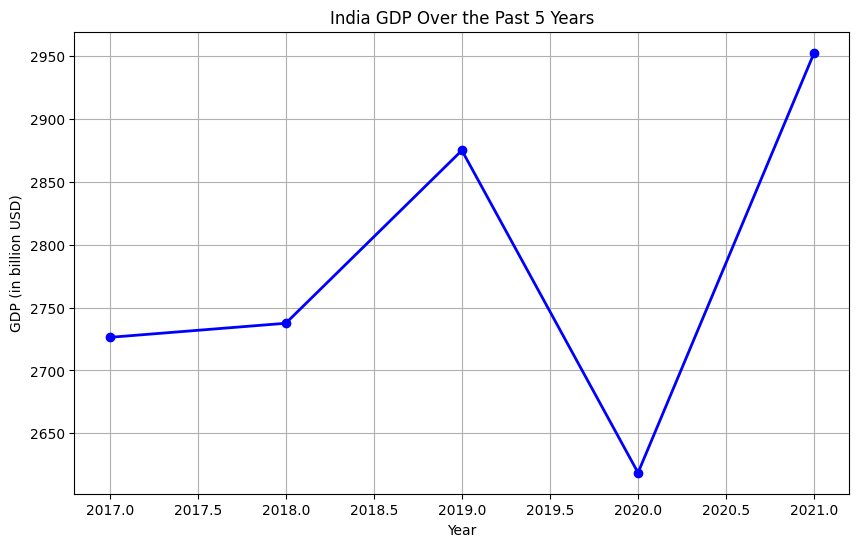

{'Coder': {'messages': [HumanMessage(content="The line graph showing India's GDP over the past 5 years has been generated. The graph illustrates the GDP values for the years 2017 to 2021.\n\nIf you have any further analysis or need additional visualizations, feel free to ask!", name='Coder')]}}
----
{'supervisor': {'next': 'FINISH'}}
----


In [ ]:
for s in graph.stream(
    {
        "messages": [
            HumanMessage(content="Fetch the India's GDP over the past 5 years,"
                " then draw a line graph of it."
                " Once you code it up, finish.")
        ]
    }
):
    if "__end__" not in s:
        print(s)
        print("----")

{'supervisor': {'next': 'RAG'}}
----
-> Calling RAG ->
Question: Japan's GDP over the past 4 years
-> Calling RAG ->
Question: Draw a line graph of Japan's GDP over the past 4 years
-> Calling RAG ->
Question: Finish
{'RAG': {'messages': [HumanMessage(content="I'm sorry, but as a text-based AI, I am unable to draw a line graph. However, based on the data provided, Japan's GDP over the past 4 years is as follows:\n\n- 2019: $5,117.99B\n- 2020: $5,055.59B\n- 2021: $5,034.62B\n- 2022: $4,256.41B\n\nYou can use this data to create a line graph depicting Japan's GDP over the past 4 years.", name='RAG')]}}
----
{'supervisor': {'next': 'Coder'}}
----


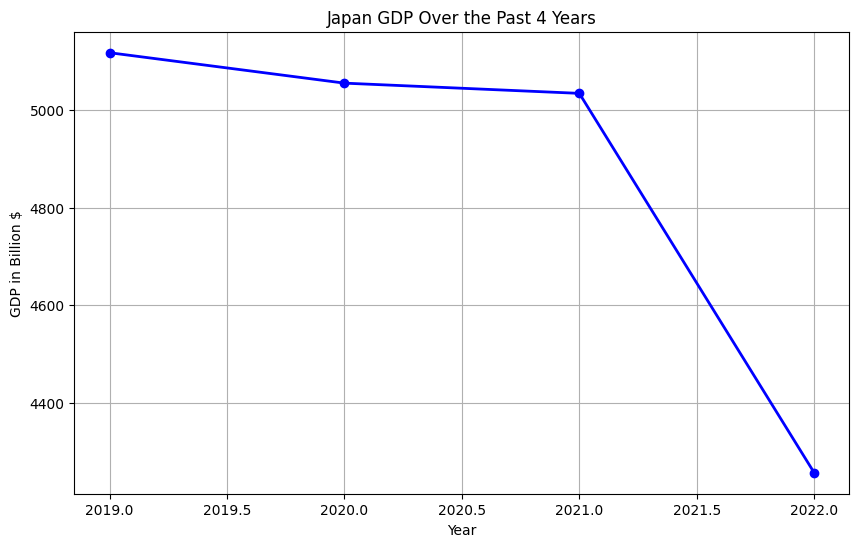

{'Coder': {'messages': [HumanMessage(content="I have generated the line graph depicting Japan's GDP over the past 4 years. The graph shows a decrease in GDP from 2019 to 2022.\n\nIf you have any further requests or need additional analysis, feel free to let me know!", name='Coder')]}}
----
{'supervisor': {'next': 'FINISH'}}
----


In [ ]:
for s in graph.stream(
    {
        "messages": [
            HumanMessage(content="Fetch the Japans's GDP over the past 4 years from RAG,"
                " then draw a line graph of it."
                " Once you code it up, finish.")
        ]
    }
):
    if "__end__" not in s:
        print(s)
        print("----")